<a href="https://colab.research.google.com/github/shreyus3003/Omdena/blob/master/labelboxtococo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import pandas as pd


In [88]:
bulky_df = pd.read_json("/content/battery.json")
bulky_df.head()

,ID,DataRow ID,Labeled Data,Label,Created By,Project Name,Created At,Updated At,Seconds to Label,External ID,Agreement,Benchmark Agreement,Benchmark ID,Dataset Name,Reviews,View Label
0,ckcm3n9of346f0yad3g174mva,ckclwe8cs091k0bqb4ibbdtwi,https://storage.labelbox.com/ckc2ghzh8sclq0756...,{'objects': [{'featureId': 'ckcm3n8ks346e0yadc...,yasamin.abbaszadegan@ryerson.ca,Battery,2020-07-14T15:37:30.000Z,2020-07-14T15:38:27.000Z,7.019,datasets_390259_753037_test_battery_battery (1...,-1.0,-1,NaN,Battery,[],https://editor.labelbox.com?project=ckclw6hfhb...
1,ckcm3ogu61ax30y9h7d8p47y7,ckclwe8cv09540bqb3iz60eeq,https://storage.labelbox.com/ckc2ghzh8sclq0756...,{'objects': [{'featureId': 'ckcm3ntv704zg0zaq8...,yasamin.abbaszadegan@ryerson.ca,Battery,2020-07-14T15:38:26.000Z,2020-07-14T15:40:54.000Z,6.928,datasets_390259_753037_test_battery_battery (4...,-1.0,-1,NaN,Battery,[],https://editor.labelbox.com?project=ckclw6hfhb...
2,ckcm3r26o051z0yalfd2f67qr,ckclwe8cw098o0bqb7np05lsi,https://storage.labelbox.com/ckc2ghzh8sclq0756...,{'objects': [{'featureId': 'ckcm3r0zy34gc0yad7...,yasamin.abbaszadegan@ryerson.ca,Battery,2020-07-14T15:40:27.000Z,2020-07-14T15:40:57.000Z,2.269,datasets_390259_753037_test_battery_battery (8...,-1.0,-1,NaN,Battery,[],https://editor.labelbox.com?project=ckclw6hfhb...
3,ckcm3rhfp1aly0yao35qz4xta,ckclwe8ct09280bqb64x3bqrq,https://storage.labelbox.com/ckc2ghzh8sclq0756...,{'objects': [{'featureId': 'ckcm3qre9056f0zaqb...,akramahmadi67@yahoo.com,Battery,2020-07-14T15:40:47.000Z,2020-07-14T15:42:01.000Z,126.832,datasets_390259_753037_test_battery_battery (1...,-1.0,-1,NaN,Battery,[],https://editor.labelbox.com?project=ckclw6hfhb...
4,ckcm3rhgt2m9d0ya3budc4ak7,ckclwe8cx09c80bqb6ncv15ms,https://storage.labelbox.com/ckc2ghzh8sclq0756...,{'objects': [{'featureId': 'ckcm3rgwe059n0zaq7...,yasamin.abbaszadegan@ryerson.ca,Battery,2020-07-14T15:40:47.000Z,2020-07-14T15:40:57.000Z,1.328,datasets_390259_753037_test_battery_battery (1...,-1.0,-1,NaN,Battery,[],https://editor.labelbox.com?project=ckclw6hfhb...


In [10]:
!pip install LBExporters

In [45]:
import labelbox2coco as lb2co

In [46]:
labeled_data = "/content/battery.json"

In [47]:
coco_output = 'lb2co_1.json'

In [49]:
lb2co.from_json(labeled_data=labeled_data, coco_output=coco_output)

KeyError: ignored

In [59]:
"""
Module for converting labelbox.com JSON exports to MS COCO format.
"""

import datetime as dt
import json
import logging
from typing import Any, Dict

from PIL import Image
import requests
from shapely import wkt
from shapely.geometry import Polygon

#from exceptions import UnknownFormatError

#LOGGER = logging.getLogger(__name__)

class UnknownFormatError(Exception):
    """Exception raised for unknown label_format"""

    def __init__(self, label_format):
        Exception.__init__(self)
        self.message = "Provided label_format '{}' is unsupported".format(label_format)

# class coco_exporter():

def make_coco_metadata(project_name: str, created_by: str) -> Dict[str, Any]:
    """Initializes COCO export data structure.
    Args:
        project_name: name of the project
        created_by: email of the project creator
    Returns:
        The COCO export represented as a dictionary.
    """
    return {
        'info': {
            'year': dt.datetime.now(dt.timezone.utc).year,
            'version': None,
            'description': project_name,
            'contributor': created_by,
            'url': 'labelbox.com',
            'date_created': dt.datetime.now(dt.timezone.utc).isoformat()
        },
        'images': [],
        'annotations': [],
        'licenses': [],
        'categories': []
    }



def from_json(labeled_data, coco_output, label_format='XY'):
    "Writes labelbox JSON export into MS COCO format."
    # read labelbox JSON output
    with open(labeled_data, 'r') as file_handle:
        label_data = json.loads(file_handle.read())

    # setup COCO dataset container and info
    coco = make_coco_metadata(label_data[0]['Project Name'], label_data[0]['Created By'],)

    for data in label_data:
        # Download and get image name
        try:
            add_label(coco, data['ID'], data['Labeled Data'], data['Label'], label_format)
        except requests.exceptions.MissingSchema as exc:
            LOGGER.warning(exc)
            continue
        except requests.exceptions.ConnectionError:
            LOGGER.warning('Failed to fetch image from %s, skipping', data['Labeled Data'])
            continue

    with open(coco_output, 'w+') as file_handle:
        file_handle.write(json.dumps(coco))




def add_label(
        coco: Dict[str, Any], label_id: str, image_url: str,
        labels: Dict[str, Any], label_format: str):
    """Incrementally updates COCO export data structure with a new label.
    Args:
        coco: The current COCO export, will be incrementally updated by this method.
        label_id: ID for the instance to write
        image_url: URL to download image file from
        labels: Labelbox formatted labels to use for generating annotation
        label_format: Format of the labeled data. Valid options are: "WKT" and
                      "XY", default is "XY".
    Returns:
        The updated COCO export represented as a dictionary.
    """
    image = {
        "id": label_id,
        "file_name": image_url,
        "license": None,
        "flickr_url": image_url,
        "coco_url": image_url,
        "date_captured": None,
    }
    response = requests.get(image_url, stream=True, timeout=10.0)
    response.raw.decode_content = True
    image['width'], image['height'] = Image.open(response.raw).size

    coco['images'].append(image)

    # remove classification labels (Skip, etc...)
    if not callable(getattr(labels, 'keys', None)):
        return

    # convert label to COCO Polygon format
    for category_name, label_data in labels.items():
      if category_name == "objects":
        category_name = label_data[0]["title"]

        try:
            # check if label category exists in 'categories' field
            category_id = [c['id']
                          for c in coco['categories']
                          if c['supercategory'] == category_name][0]
        except IndexError:
            category_id = len(coco['categories']) + 1
            category = {
                'supercategory': category_name,
                'id': category_id,
                'name': category_name
            }
            coco['categories'].append(category)

        polygons = _get_polygons(label_format, label_data)
        _append_polygons_as_annotations(coco, image, category_id, polygons)


def _append_polygons_as_annotations(coco, image, category_id, polygons):
    "Adds `polygons` as annotations in the `coco` export"
    for polygon in polygons:
        segmentation = []
        for x_val, y_val in polygon.exterior.coords:
            segmentation.extend([x_val, y_val])

        annotation = {
            "id": len(coco['annotations']) + 1,
            "image_id": image['id'],
            "category_id": category_id,
            "segmentation": [segmentation],
            "area": polygon.area,  # float
            "bbox": [polygon.bounds[0], polygon.bounds[1],
                    polygon.bounds[2] - polygon.bounds[0],
                    polygon.bounds[3] - polygon.bounds[1]],
            "iscrowd": 0
        }

        coco['annotations'].append(annotation)


def _get_polygons(label_format, label_data):
    "Converts segmentation `label: String!` into polygons"
    if label_format == 'WKT':
        if isinstance(label_data, list):  # V3
            # polygons = map(lambda x: wkt.loads(x['geometry']), label_data)
            polygons = map(lambda x: wkt.loads(x['polygon']), label_data)
        else:  # V2
            polygons = wkt.loads(label_data)
    elif label_format == 'XY':
        polygons = []
        for xy_list in label_data:
            # if 'geometry' in xy_list:  # V3
            #     xy_list = xy_list['geometry']
            if 'polygon' in xy_list:  # V3
                xy_list = xy_list['polygon']

                # V2 and V3
                if not isinstance(xy_list, list):
                    LOGGER.warning('Could not get an point list to construct polygon, skipping')
                    continue
            else:  # V2, or non-list
                if not isinstance(xy_list, list) or not xy_list or 'x' not in xy_list[0]:
                    # skip non xy lists
                    LOGGER.warning('Could not get an point list to construct polygon, skipping')
                    continue

            if len(xy_list) > 2:  # need at least 3 points to make a polygon
                polygons.append(Polygon(map(lambda p: (p['x'], p['y']), xy_list)))
    else:
        exc = UnknownFormatError(label_format=label_format)
        LOGGER.exception(exc.message)
        raise exc

    return polygons

In [73]:
import argparse
import json
import os
import logging
import traceback as tb

# import coco_exporter

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

def export(file_input, file_output):
    "Uses COCO exporter function from_json to convert labelbox JSON into MS COCO format."

    try:
        artifact = '{}/coco.json'.format(file_output)
        # os.makedirs(file_output, exist_ok=True)
        # LOGGER.info('Creating coco export')

        # coco_exporter.from_json(file_input, artifact)
        from_json(file_input, artifact)

        LOGGER.info('Done saving coco export')

    except Exception as e:
        tb.print_exc()


if __name__ == '__main__':
    # parser = argparse.ArgumentParser()
    # parser.add_argument('file_input', help='File path to Labelbox JSON to parse export')
    # parser.add_argument('file_output', help='File path to desired output directory for export asset')

    # args = parser.parse_args()

    file_input = '/content/cardboard.json'
    

    file_output = '/content/cardboard'
    # assert file_output

    export(file_input, file_output)

INFO:__main__:Done saving coco export


In [74]:
annotation_path = '/content/cardboard/coco.json'

In [75]:
with open(annotation_path) as json_file:
    lines = json_file.readlines()
for line in lines:
    print(line)

{"info": {"year": 2020, "version": null, "description": "Cardboard", "contributor": "shreyus.p3003@gmail.com", "url": "labelbox.com", "date_created": "2020-07-29T07:17:35.565824+00:00"}, "images": [{"id": "ckcrw87li00003h600qhrv41h", "file_name": "https://storage.labelbox.com/ckc2ghzh8sclq0756nkmp5ktj%2Ff323adeb-96f6-1c1e-eb16-1b944d285951-cardboard390.jpg?Expires=1597162999515&KeyName=labelbox-assets-key-1&Signature=LlzUOstAEv5SR4anyus5V-GuhlQ", "license": null, "flickr_url": "https://storage.labelbox.com/ckc2ghzh8sclq0756nkmp5ktj%2Ff323adeb-96f6-1c1e-eb16-1b944d285951-cardboard390.jpg?Expires=1597162999515&KeyName=labelbox-assets-key-1&Signature=LlzUOstAEv5SR4anyus5V-GuhlQ", "coco_url": "https://storage.labelbox.com/ckc2ghzh8sclq0756nkmp5ktj%2Ff323adeb-96f6-1c1e-eb16-1b944d285951-cardboard390.jpg?Expires=1597162999515&KeyName=labelbox-assets-key-1&Signature=LlzUOstAEv5SR4anyus5V-GuhlQ", "date_captured": null, "width": 512, "height": 384}, {"id": "ckcrw92zu00013h60nvh53f8q", "file_nam

In [ ]:
!unzip '/content/bulky_plastic/5.Bulky rigid plastic-20200726T071226Z-001.zip'

In [ ]:
!unzip '/content/drive/My Drive/omdena/Battery.zip'

# to check the coco json file.


In [76]:
from pycocotools.coco import COCO

dataDir='/content/15.Battery'
dataType='val'
annFile='/content/cardboard/coco.json'.format(dataDir,dataType)

#annFile = '/content/battery/coco.json'

In [77]:
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [78]:
catIDs = coco.getCatIds(catNms=[])
cats = coco.loadCats(catIDs)

print(cats)

[{'supercategory': 'Cardboard', 'id': 1, 'name': 'Cardboard'}]


In [79]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"
print('The class name is', getClassName(1, cats))

The class name is Cardboard


catIDs are  []
ckcs0h74u00033h60ocq9vp1v
Number of images containing all the  classes: 596
ckcrw87li00003h600qhrv41h


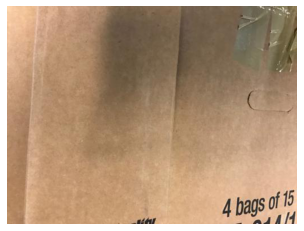

ckcrw92zu00013h60nvh53f8q


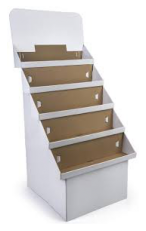

ckcrwagnp00023h604gfqqzor


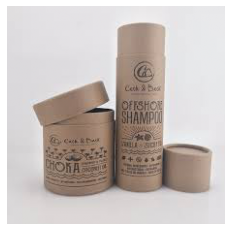

ckcs0fm4e00003h60puwv6top


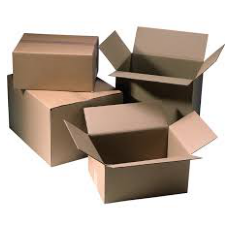

ckcs0fz1600013h60armlo2eo


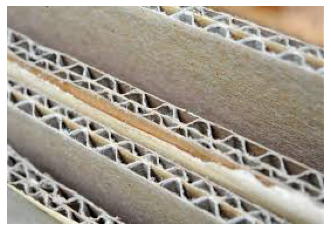

ckcs0g9vc00023h60yqit2dkt


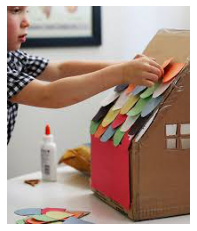

ckcs0h74u00033h60ocq9vp1v


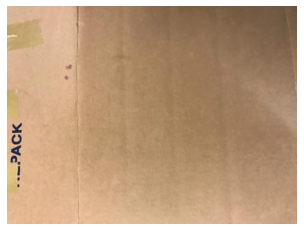

ckcs0hjc900043h60fbg4de1w


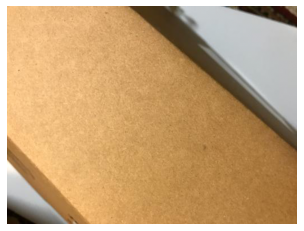

ckcs0hy3600053h60pzkwx2es


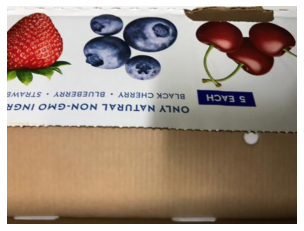

ckcs0i9in00063h60j0eyop0s


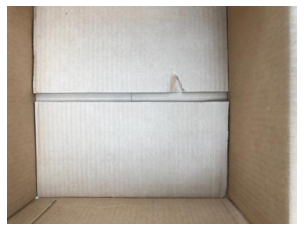

In [86]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt


filterClasses = ['classifications']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses)
print("catIDs are ", catIds) 
# Get all images containing the above Category IDs
# imgIds = coco.getImgIds(catIds=catIds)
imgIds = coco.getImgIds(imgIds=[])
print(imgIds[6])
print("Number of images containing all the  classes:", len(imgIds))

# load and display a random image
#img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[2]
for i in range(10):
  img = coco.loadImgs(imgIds)[i]
  I = io.imread(img['file_name'])/255.0
  print(img['id'])
  plt.axis('off')
  plt.imshow(I)
  plt.show()
#img

# img = coco.loadImgs(imgIds)[6]
# #I = io.imread('{}/images/{}/{}'.format(dataDir,dataType,img['file_name']))/255.0
# I = io.imread(img['file_name'])/255.0

# plt.axis('off')
# plt.imshow(I)
# plt.show()
# img

ckcs0h74u00033h60ocq9vp1v
[]
[]


0

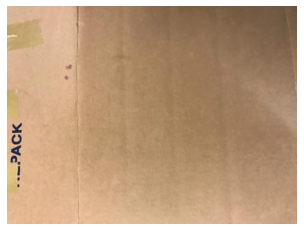

In [81]:
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
print(img['id'])
print(catIds)
print(annIds)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

# Visualize COCO data images.

In [69]:
import argparse
import json
import os
import logging
import traceback as tb
from PIL import Image as PILImage

In [70]:
class CocoDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        self.colors = ['blue', 'purple', 'red', 'green', 'orange', 'salmon', 'pink', 'gold',
                       'orchid', 'slateblue', 'limegreen', 'seagreen', 'darkgreen', 'olive',
                       'teal', 'aquamarine', 'steelblue', 'powderblue', 'dodgerblue', 'navy',
                       'magenta', 'sienna', 'maroon']

        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()

        self.process_info()
        self.process_licenses()
        self.process_categories()
        self.process_images()
        self.process_segmentations()

    def display_info(self):
        print('Dataset Info:')
        print('=============')
        if self.info is None:
            return
        for key, item in self.info.items():
            print('  {}: {}'.format(key, item))

        requirements = [['description', str],
                        ['url', str],
                        ['version', str],
                        ['year', int],
                        ['contributor', str],
                        ['date_created', str]]
        for req, req_type in requirements:
            if req not in self.info:
                print('ERROR: {} is missing'.format(req))
            elif type(self.info[req]) != req_type:
                print('ERROR: {} should be type {}'.format(req, str(req_type)))
        print('')

    def display_licenses(self):
        print('Licenses:')
        print('=========')

        if self.licenses is None:
            return
        requirements = [['id', int],
                        ['url', str],
                        ['name', str]]
        for license in self.licenses:
            for key, item in license.items():
                print('  {}: {}'.format(key, item))
            for req, req_type in requirements:
                if req not in license:
                    print('ERROR: {} is missing'.format(req))
                elif type(license[req]) != req_type:
                    print('ERROR: {} should be type {}'.format(
                        req, str(req_type)))
            print('')
        print('')

    def display_categories(self):
        print('Categories:')
        print('=========')
        for sc_key, sc_val in self.super_categories.items():
            print('  super_category: {}'.format(sc_key))
            for cat_id in sc_val:
                print('    id {}: {}'.format(
                    cat_id, self.categories[cat_id]['name']))
            print('')

    def display_image(self, image_id, show_polys=True, show_bbox=True, show_crowds=True, use_url=False):
        print('Image:')
        print('======')
        if image_id == 'random':
            image_id = random.choice(list(self.images.keys()))

        # Print the image info
        image = self.images[image_id]
        print(image)
        for key, val in image.items():
            print('  {}: {}'.format(key, val))

        # Open the image
        if use_url:
            image_path = image['coco_url']
            response = requests.get(image_path)
            image = PILImage.open(BytesIO(response.content))

        else:
            image_path = os.path.join(self.image_dir, image['file_name'])
            image = PILImage.open(image_path)

        # Calculate the size and adjusted display size
        max_width = 600
        image_width, image_height = image.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height

        # Create list of polygons to be drawn
        polygons = {}
        bbox_polygons = {}
        rle_regions = {}
        poly_colors = {}
        bbox_categories = {}
        print('  segmentations ({}):'.format(
            len(self.segmentations[image_id])))
        for i, segm in enumerate(self.segmentations[image_id]):
            polygons_list = []
            if segm['iscrowd'] != 0:
                # Gotta decode the RLE
                px = 0
                x, y = 0, 0
                rle_list = []
                for j, counts in enumerate(segm['segmentation']['counts']):
                    if j % 2 == 0:
                        # Empty pixels
                        px += counts
                    else:
                        # Need to draw on these pixels, since we are drawing in vector form,
                        # we need to draw horizontal lines on the image
                        x_start = trunc(
                            trunc(px / image_height) * adjusted_ratio)
                        y_start = trunc(px % image_height * adjusted_ratio)
                        px += counts
                        x_end = trunc(trunc(px / image_height)
                                      * adjusted_ratio)
                        y_end = trunc(px % image_height * adjusted_ratio)
                        if x_end == x_start:
                            # This is only on one line
                            rle_list.append(
                                {'x': x_start, 'y': y_start, 'width': 1, 'height': (y_end - y_start)})
                        if x_end > x_start:
                            # This spans more than one line
                            # Insert top line first
                            rle_list.append(
                                {'x': x_start, 'y': y_start, 'width': 1, 'height': (image_height - y_start)})

                            # Insert middle lines if needed
                            lines_spanned = x_end - x_start + 1  # total number of lines spanned
                            full_lines_to_insert = lines_spanned - 2
                            if full_lines_to_insert > 0:
                                full_lines_to_insert = trunc(
                                    full_lines_to_insert * adjusted_ratio)
                                rle_list.append(
                                    {'x': (x_start + 1), 'y': 0, 'width': full_lines_to_insert, 'height': image_height})

                            # Insert bottom line
                            rle_list.append(
                                {'x': x_end, 'y': 0, 'width': 1, 'height': y_end})
                if len(rle_list) > 0:
                    rle_regions[segm['id']] = rle_list
            else:
                # Add the polygon segmentation
                for segmentation_points in segm['segmentation']:
                    segmentation_points = np.multiply(
                        segmentation_points, adjusted_ratio).astype(int)
                    polygons_list.append(
                        str(segmentation_points).lstrip('[').rstrip(']'))
            polygons[segm['id']] = polygons_list
            if i < len(self.colors):
                poly_colors[segm['id']] = self.colors[i]
            else:
                poly_colors[segm['id']] = 'white'

            bbox = segm['bbox']
            bbox_points = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1],
                           bbox[0] + bbox[2], bbox[1] +
                           bbox[3], bbox[0], bbox[1] + bbox[3],
                           bbox[0], bbox[1]]
            bbox_points = np.multiply(bbox_points, adjusted_ratio).astype(int)
            bbox_polygons[segm['id']] = str(
                bbox_points).lstrip('[').rstrip(']')
            bbox_categories[segm['id']] = self.categories[segm['category_id']]
            # Print details
            print('    {}:{}:{}'.format(
                segm['id'], poly_colors[segm['id']], self.categories[segm['category_id']]))

        # Draw segmentation polygons on image
        html = '<div class="container" style="position:relative;">'
        html += '<img src="{}" style="position:relative;top:0px;left:0px;width:{}px;">'.format(
            image_path, adjusted_width)
        html += '<div class="svgclass"><svg width="{}" height="{}">'.format(
            adjusted_width, adjusted_height)

        if show_polys:
            for seg_id, points_list in polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for points in points_list:
                    html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5" />'.format(
                        points, fill_color, stroke_color)

        if show_crowds:
            for seg_id, rect_list in rle_regions.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for rect_def in rect_list:
                    x, y = rect_def['x'], rect_def['y']
                    w, h = rect_def['width'], rect_def['height']
                    html += '<rect x="{}" y="{}" width="{}" height="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5; stroke-opacity:0.5" />'.format(
                        x, y, w, h, fill_color, stroke_color)

        if show_bbox:
            for seg_id, points in bbox_polygons.items():
                x, y = [int(i) for i in points.split()[:2]]
                html += '<text x="{}" y="{}" fill="yellow">{}</text>'.format(
                    x, y, bbox_categories[seg_id]["name"])
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0" />'.format(
                    points, fill_color, stroke_color)

        html += '</svg></div>'
        html += '</div>'
        html += '<style>'
        html += '.svgclass { position:absolute; top:0px; left:0px;}'
        html += '</style>'
        return html

    def process_info(self):
        self.info = self.coco.get('info')

    def process_licenses(self):
        self.licenses = self.coco.get('licenses')

    def process_categories(self):
        self.categories = {}
        self.super_categories = {}
        for category in self.coco['categories']:
            cat_id = category['id']
            super_category = category['supercategory']

            # Add category to the categories dict
            if cat_id not in self.categories:
                self.categories[cat_id] = category
            else:
                print("ERROR: Skipping duplicate category id: {}".format(category))

            # Add category to super_categories dict
            if super_category not in self.super_categories:
                # Create a new set with the category id
                self.super_categories[super_category] = {cat_id}
            else:
                self.super_categories[super_category] |= {
                    cat_id}  # Add category id to the set

    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print("ERROR: Skipping duplicate image id: {}".format(image))
            else:
                self.images[image_id] = image

    def process_segmentations(self):
        self.segmentations = {}
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)

In [82]:
annotation_path = '/content/cardboard/coco.json'
image_dir = '/content/15.Battery'

print(annotation_path)
coco_dataset = CocoDataset(annotation_path, image_dir)
coco_dataset.display_info()
coco_dataset.display_licenses()
coco_dataset.display_categories()

/content/cardboard/coco.json
Dataset Info:
  year: 2020
  version: None
  description: Cardboard
  contributor: shreyus.p3003@gmail.com
  url: labelbox.com
  date_created: 2020-07-29T07:17:35.565824+00:00
ERROR: version should be type <class 'str'>

Licenses:

Categories:
  super_category: Cardboard
    id 1: Cardboard



In [99]:

import requests 
from io import BytesIO
import numpy as np
import IPython
import time
for i in range(10):
  img = coco.loadImgs(imgIds)[i]
  I = io.imread(img['file_name'])/255.0
  print(img['id'])
html = coco_dataset.display_image('ckcrw92zu00013h60nvh53f8q', use_url=True)

IPython.display.HTML(html)


ckcrw87li00003h600qhrv41h
ckcrw92zu00013h60nvh53f8q
ckcrwagnp00023h604gfqqzor
ckcs0fm4e00003h60puwv6top
ckcs0fz1600013h60armlo2eo
ckcs0g9vc00023h60yqit2dkt
ckcs0h74u00033h60ocq9vp1v
ckcs0hjc900043h60fbg4de1w
ckcs0hy3600053h60pzkwx2es
ckcs0i9in00063h60j0eyop0s
Image:
{'id': 'ckcrw92zu00013h60nvh53f8q', 'file_name': 'https://storage.labelbox.com/ckc2ghzh8sclq0756nkmp5ktj%2Fd260e126-f711-9ab6-7a33-0d50d8a8da56-00000029.jpg?Expires=1597162999516&KeyName=labelbox-assets-key-1&Signature=n0b85txhi4iC5dKXs5SVd2G3yZs', 'license': None, 'flickr_url': 'https://storage.labelbox.com/ckc2ghzh8sclq0756nkmp5ktj%2Fd260e126-f711-9ab6-7a33-0d50d8a8da56-00000029.jpg?Expires=1597162999516&KeyName=labelbox-assets-key-1&Signature=n0b85txhi4iC5dKXs5SVd2G3yZs', 'coco_url': 'https://storage.labelbox.com/ckc2ghzh8sclq0756nkmp5ktj%2Fd260e126-f711-9ab6-7a33-0d50d8a8da56-00000029.jpg?Expires=1597162999516&KeyName=labelbox-assets-key-1&Signature=n0b85txhi4iC5dKXs5SVd2G3yZs', 'date_captured': None, 'width': 175, 'hei

In [25]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

In [26]:
annotation_file = '/content/bulky_plastic/coco.json'

In [27]:
example_coco = COCO(annotation_file)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [28]:
categories = example_coco.loadCats(example_coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

category_names = set([category['supercategory'] for category in categories])
print('Custom COCO supercategories: \n{}'.format(' '.join(category_names)))

Custom COCO categories: 
objects classifications

Custom COCO supercategories: 
classifications objects


In [35]:
category_ids = example_coco.getCatIds(catNms=['rigid Plastic'])
image_ids = example_coco.getImgIds(catIds=category_ids)
image_data = example_coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]

KeyError: ignored